# Building Univariate Time Series Models Using Statistical Methods

When working with time series data, different methods and models can be used, depending on whether the time series is univariate or multivariate, seasonal or non-seasonal, stationary or non-stationary, and linear or non-linear. Some popular statistical modeling methods include exponential smoothing, non-seasonal autoregressive integrated moving average (ARIMA), seasonal ARIMA (SARIMA), Vector Autoregressive (VAR) and other variants of these models. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.api import (kpss, adfuller,seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product

warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]

life_expectancy_birth_url = 'https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/life_expectancy_birth.csv'
milk_production_url = 'https://raw.githubusercontent.com/PacktPublishing/Time-Series-Analysis-with-Python-Cookbook/main/datasets/Ch10/milk_production.csv'

life = pd.read_csv(life_expectancy_birth_url,
                            index_col='year',
                            parse_dates=True,
                            skipfooter=1)

milk = pd.read_csv(milk_production_url,
                    index_col='month',
                    parse_dates=True)

<AxesSubplot:title={'center':'Monthly Milk Production'}, xlabel='month'>

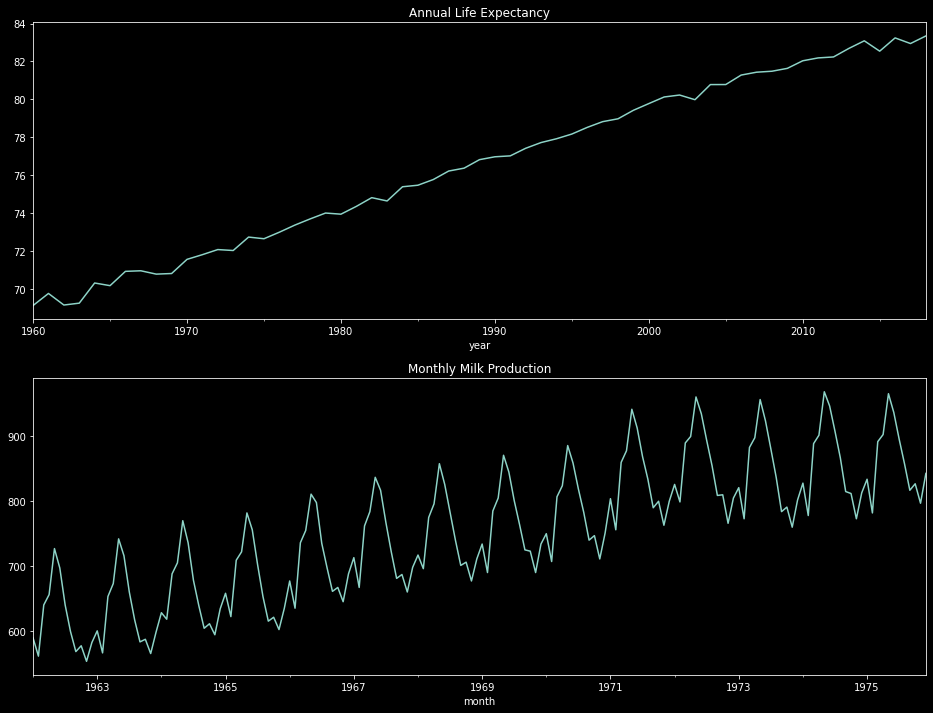

In [3]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title='Annual Life Expectancy',
legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production',
legend=False, ax=ax[1])

In [ ]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [ ]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

In [ ]:
#Check for stationarity:

def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

There will be scenarios where you might run multiple variations of a model to search for optimal configuration (hyperparameter tunning). To get the best_model function, we can construct a *get_best_model* function, that will take a dictionary that contains the produced model, parameters_used and the scores for each model. This model will return the winner based on a score metric. This is the c parameter, which by defaults is the AIC. For instance you might use *Mean Squared Percentage Error (RMSPE)*, *Root Mean Square Error (RMSE)*, *Mean Square Error (MSE)*, *Akaike's Information Criterion (AIC)*, *Corrected Akaike's Information Criteria (AICc)* and *Bayesian Information Criteria (BIC)*

In [ ]:
def get_best_model(score, c='AIC'):
    initial_score = score[0][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score['best_model']['model']

In [ ]:
# Plot forecast function:

def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]),index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    plt.show()

In [ ]:
def combinator(items):
    combo = [i for i in product(*items)]
    return combo

## Plotting ACF and PACF